<a href="https://colab.research.google.com/github/jessicasilvacodes/pln-pucminas/blob/main/pln_03_aquisicao_dados_enriquecimento_pucminas_JessicaSilva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aquisição de dados com enriquecimento de dados** - Data Augmentation

Data Augmentation, ou Enriquecimento de Dados, é uma técnica utilizada para aumentar artificialmente o conjunto de dados de treinamento em aprendizado de máquina, especialmente quando se lida com conjuntos de dados pequenos ou desbalanceados. Em vez de coletar mais dados, o aumento de dados envolve a criação de novas amostras a partir dos dados existentes, através de transformações como rotações, cortes, mudanças de cor, substituição de sinônimos, inserção de palavras, tradução reversa, remoção de palavras, etc.

Motivação:
- conjuntos de dados limitados
- melhoria da generalização do modelo
- balanceamento de dados
- robustez a ruídos e erros
- adaptação a diferentes dialetos
- teste e avaliação de modelos

**NLPaug** é a biblioteca Python usada para aumentar dados de texto.

In [1]:
# Instala pacotes para enriquecimento e análise de dados.
!pip install matplotlib
!pip install nlpaug
!pip install numpy
!pip install pandas
!pip install requests
!pip install scikit-learn
!pip install seaborn
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.9 MB/s eta 0:00:00


In [2]:
# Declara define funções utilitárias utilizadas no notebook.
import datetime
def formata_msg(nivel, msg, componente=None):
    """
    Formata uma mensagem de log incluindo o nível de severidade, timestamp,
    componente (opcional) e a mensagem.

    Parâmetros:
    - nivel (str): Nível de severidade da mensagem (ex: 'INFO', 'ERROR', 'WARNING').
    - msg (str): A mensagem de log propriamente dita.
    - componente (str, opcional): O componente ou módulo do sistema que gera a mensagem.

    Retorna:
    - str: A mensagem de log formatada.
    """
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    if componente:
        return f"[{nivel}] {timestamp} - {componente}: {msg}"
    else:
        return f"[{nivel}] {timestamp} - {msg}"

def plotar_distribuicao_polaridade(df):
    """
    Função para plotar um gráfico de barras da contagem de valores para a coluna 'polarity'.

    Parâmetros:
    df (DataFrame): O DataFrame contendo a coluna 'polarity' a ser analisada.

    Esta função utiliza a biblioteca seaborn para criar um gráfico de barras que
    mostra a contagem de ocorrências para cada valor único na coluna 'polarity'.
    Os rótulos dos eixos são removidos para uma apresentação mais limpa, e as bordas
    esquerdas são também removidas.
    """

    # Realiza a contagem de valores na coluna 'polarity' e armazena o resultado
    polarity_counts = df['polarity'].value_counts()

    # Cria o gráfico de barras usando seaborn, definindo os valores do eixo x e y
    sns.barplot(x=polarity_counts.index, y=polarity_counts, hue=polarity_counts.index, legend=False)

    # Configurações para remover rótulos e títulos desnecessários do gráfico
    plt.yticks([], [])  # Remove os rótulos do eixo y para simplificar a visualização
    plt.xlabel('')      # Limpa o título do eixo x para uma apresentação mais limpa
    plt.ylabel('')      # Limpa o título do eixo y para uma apresentação mais limpa
    sns.despine(left=True)  # Remove a borda esquerda do gráfico para um design mais minimalista

    # Loop para adicionar rótulos de texto em cada barra do gráfico, melhorando a interpretabilidade
    for container in plt.gca().containers:
        plt.gca().bar_label(container)  # Adiciona rótulos nas barras com a contagem de cada 'polarity'

print(formata_msg("INFO", f"Funções utilitárias foram declaradas, prontas para utilização."))

[INFO] 2025-07-30 19:13:50 - Funções utilitárias foram declaradas, prontas para utilização.


In [3]:
# Importação da biblioteca padrão
import os

# Importação de bibliotecas de terceiros
import matplotlib.pyplot as plt
import nlpaug.augmenter.word as naw
import numpy as np
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm

print(formata_msg("INFO", "Bibliotecas importadas com sucesso; ambiente pronto."))

[INFO] 2025-07-30 19:14:22 - Bibliotecas importadas com sucesso; ambiente pronto.


In [4]:
# Define o diretório local para armazenar as bases de dados públicas coletadas.
corpora_caminho = "./corpora"

# Verifica se o diretório especificado já existe no ambiente do Colab.
if not os.path.exists(corpora_caminho):
  # Caso o diretório não exista, cria um novo diretório com o nome 'corpora'.
  # Isso é útil para organizar os arquivos de dados baixados ou gerados.
  os.mkdir(corpora_caminho)

print(formata_msg("INFO", f"Diretório {corpora_caminho} foi criado com sucesso."))

[INFO] 2025-07-30 19:14:22 - Diretório ./corpora foi criado com sucesso.


## Base de dados de comentários do Buscapé
Buscapé é uma plataforma de comércio eletrônico brasileiro. O Buscapé funciona como um assistente de compras, para que os consumidores pesquisem produtos, preços, promoções e lojas.O Buscapé pertence à Mosaico Tecnologia ao Consumidor, que também é dona de outras plataformas de e-commerce.

In [5]:
# Define a URL da base pública armazenada no Github.
url = "https://raw.githubusercontent.com/gomesluiz/product-review-analytics/main/data/raw/buscape.csv"

# Configuração do arquivo para armazenamento da base de dados.
buscape_arquivo = "buscape-comentarios.csv"

# O método os.path.join cria o caminho completo para o arquivo, combinando
# 'corpora_caminho' com o nome do arquivo.
buscape_caminho = os.path.join(corpora_caminho, buscape_arquivo)

# Define o formato do arquivo. Necessário para arquivos textos
# armazenados no raw.githubusercontent.com.
parametros = {"downloadformat": "csv"}

# Executa o download do arquivo especificado na URL com os parâmetros
# especificados
resposta = requests.get(url, params=parametros)
if resposta.status_code == 200:
  # Se o status for igual a 200 (sucesso), grava o arquivo no caminho
  # especificado
  with open(buscape_caminho, "wb") as f:
    f.write(resposta.content)
  print(formata_msg("INFO",f"Download do arquivo {buscape_arquivo} concluído com sucesso!"))
else:
  print(f"Falha no download do arquivo {buscape_arquivo}:", resposta.status_code)


[INFO] 2025-07-30 19:14:30 - Download do arquivo buscape-comentarios.csv concluído com sucesso!


In [19]:
# O comando head do linux mostra as cinco primeiras linhas do arquivo gravado.
!head -n 30 {buscape_caminho}

original_index,review_text,review_text_processed,review_text_tokenized,polarity,rating,kfold_polarity,kfold_rating
4_55516,"Estou muito satisfeito, o visor é melhor do que eu imaginava, boas imagens, desing ultra fino. Pelo preço é um exelente aparelho.

O que gostei: Desing exelente, display, custo beneficio.

O que não gostei: Não tem como adicionar mais papeis de parede, bateria dura pouco.","estou muito satisfeito, o visor e melhor do que eu imaginava, boas imagens, desing ultra fino. pelo preco e um exelente aparelho.

o que gostei: desing exelente, display, custo beneficio.

o que nao gostei: nao tem como adicionar mais papeis de parede, bateria dura pouco.","['estou', 'muito', 'satisfeito', 'visor', 'melhor', 'do', 'que', 'eu', 'imaginava', 'boas', 'imagens', 'desing', 'ultra', 'fino', 'pelo', 'preco', 'um', 'exelente', 'aparelho', 'que', 'gostei', 'desing', 'exelente', 'display', 'custo', 'beneficio', 'que', 'nao', 'gostei', 'nao', 'tem', 'como', 'adicionar', 'mais', 'papeis', 

In [7]:
# Lista das colunas específicas para serem lidas do arquivo CSV.
colunas_desejadas = ['review_text', 'polarity']

# Carrega dados do CSV usando as colunas definidas.
buscape_df = pd.read_csv(buscape_caminho, usecols=colunas_desejadas)

# Mostra o número de linhas e colunas do dataFrame buscape_df.
num_rows, num_cols = buscape_df.shape[0], buscape_df.shape[1]
print(formata_msg("INFO", f"O dataset tem {num_rows} linnhas e {num_cols} colunas."))

[INFO] 2025-07-30 19:14:31 - O dataset tem 84991 linnhas e 2 colunas.


In [8]:
# Remove todas as linhas do DataFrame que contêm valores nulos.
buscape_df.dropna(inplace=True)

# Mostra o número de linhas e colunas do dataFrame buscape_df.
num_rows, num_cols = buscape_df.shape[0], buscape_df.shape[1]
print(formata_msg("INFO", f"O dataset tem {num_rows} linnhas e {num_cols} colunas."))

[INFO] 2025-07-30 19:14:32 - O dataset tem 73626 linnhas e 2 colunas.


In [20]:
# Exibe as primeiras 5 linhas do DataFrame 'buscape_df' para uma rápida inspeção.
buscape_df.head(10)

,review_text,polarity
0,"Estou muito satisfeito, o visor é melhor do qu...",1
1,"""muito boa\n\nO que gostei: preco\n\nO que não...",1
2,"Rápida, ótima qualidade de impressão e fácil d...",1
3,Produto de ótima qualidade em todos os quesito!,1
4,Precisava comprar uma tv compatível com meu dv...,1
5,"eu adorei este secador é muito bom,potente e d...",1
7,positiva\n\nO que gostei: cumpriu com as espec...,1
8,"Muito satisfeita com o telefone, atendeu as mi...",1
9,Estou muito contente com a utlização da maquin...,1
10,Excelente produto. Estou satisfeita com o resu...,1


Garantindo que a polaridade seja um número inteiro:

In [21]:
# Converte os valores da coluna 'polarity' para string.
buscape_df['polarity'] = buscape_df['polarity'].astype(int)

# Exibe as primeiras 5 linhas do DataFrame 'buscape_df' para uma rápida inspeção.
buscape_df.head(10)

,review_text,polarity
0,"Estou muito satisfeito, o visor é melhor do qu...",1
1,"""muito boa\n\nO que gostei: preco\n\nO que não...",1
2,"Rápida, ótima qualidade de impressão e fácil d...",1
3,Produto de ótima qualidade em todos os quesito!,1
4,Precisava comprar uma tv compatível com meu dv...,1
5,"eu adorei este secador é muito bom,potente e d...",1
7,positiva\n\nO que gostei: cumpriu com as espec...,1
8,"Muito satisfeita com o telefone, atendeu as mi...",1
9,Estou muito contente com a utlização da maquin...,1
10,Excelente produto. Estou satisfeita com o resu...,1


Quantidade de registros por polaridade:

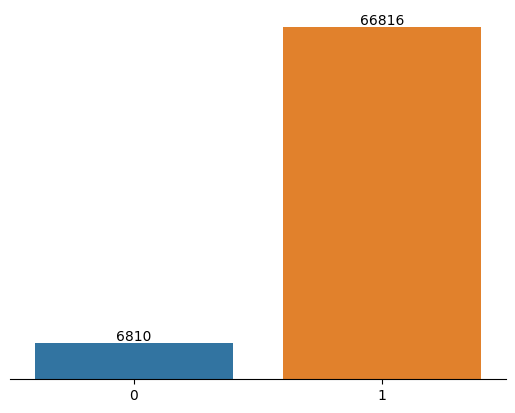

In [11]:
# Plota um gráfico de barras as categorias de polaridade.
plotar_distribuicao_polaridade(buscape_df)

Exemplo:

In [12]:
# Seleciona uma linha específica do dataFrame 'buscape_df' usando 'iloc' para
# testes do enriquecimento de dados.
texto = buscape_df.iloc[5]['review_text'].replace("\n", " ")
print(texto)

eu adorei este secador é muito bom,potente e deixa meu cabelo lindo


### Teste de enriquecimento de dados:

In [13]:
# Inicializando o augmentador com o modelo BERT em português
# para inserir palavras contextualmente apropriadas
enriquecedor = naw.ContextualWordEmbsAug(
    model_path='neuralmind/bert-base-portuguese-cased', action="insert")

# Exibindo o texto original
print("Texto original:")
print(texto)

# Exibindo o texto enriquecido
print("Texto enriquecido:")
for ii in range(5):
    print(enriquecedor.augment(texto))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Texto original:
eu adorei este secador é muito bom,potente e deixa meu cabelo lindo
Texto enriquecido:


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

['nossa eu adorei este secador é muito bom, seu potente tira e deixa mais meu seu cabelo assim lindo']
['nossa eu super adorei este aparelho secador é simplesmente muito m bom, potente e deixa meu cabelo todo lindo']
['Como eu adorei pois este novo secador é muito bom, potente e deixa bem meu segundo cabelo todo lindo']
['meu eu adorei e este do secador é sim muito bom, extremamente potente e deixa muito meu cabelo lindo']
['eu adorei este aparelho secador pois é que muito bom, potente e agora deixa perfeitamente meu cabelo com lindo']


Divisão do conjunto de dados em treinamento (80%) e teste (20%):

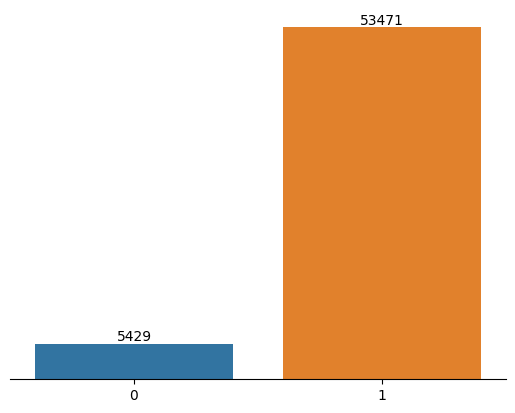

In [14]:
# Divisão do DataFrame 'buscape_df' em conjuntos de treino e teste.
train, test = train_test_split(buscape_df, test_size=0.20, random_state=42)

# plotar a distribuição de polaridade no conjunto de treino
plotar_distribuicao_polaridade(train)

**Não podemos fazer o enriquecimento no conjunto de testes!!!**

### Enriquecimento de dados:

In [15]:
def enriquecer_texto(enriquecedor, df, classe, amostras=100, prob_aug=0.2):
    """
    Enriquece textos de uma determinada classe em um DataFrame usando enriquecimento.

    A função seleciona aleatoriamente um conjunto de textos da classe especificada
    e aplica a augmentação para gerar novos textos. Esses textos são adicionados ao
    DataFrame original, criando uma versão enriquecida do mesmo.

    Args:
        enriquecedor: Objeto utilizado para realizar a augmentação dos textos.
        df (pd.DataFrame): DataFrame contendo os textos e suas respectivas classes.
        classe (int/str): A classe dos textos que serão enriquecidos.
        amostras (int, optional): Número de textos da classe especificada a serem enriquecidos.
            Padrão é 100.
        prob_aug (float, optional): Probabilidade de cada palavra ser augmentada.
            Padrão é 0.2.

    Returns:
        pd.DataFrame: DataFrame original com os textos enriquecidos adicionados,
        embaralhado de forma aleatória.
    """

    # Define a probabilidade de augmentação para o enriquecedor
    enriquecedor.aug_p = prob_aug

    # Inicializa a lista para armazenar textos enriquecidos
    textos_enriquecidos = []

    # Filtra o DataFrame para obter apenas as entradas da classe especificada
    df_minoritario = df[df.polarity == classe].reset_index(drop=True)

    # Loop para enriquecer uma quantidade específica de amostras aleatórias
    for i in tqdm(np.random.randint(0, len(df_minoritario), amostras)):
        texto = df_minoritario.iloc[i]['review_text']
        texto_enriquecido = enriquecedor.augment(texto)
        textos_enriquecidos.append(texto_enriquecido)

    # Cria um DataFrame com os textos enriquecidos e a classe-alvo
    df_enriquecido = pd.DataFrame({'review_text': textos_enriquecidos, 'polarity': classe})

    # Combina o DataFrame original com o DataFrame enriquecido e embaralha
    df_resultante = pd.concat([df, df_enriquecido], ignore_index=True).sample(frac=1, random_state=42)

    # Retorna o DataFrame resultante
    return df_resultante

print(formata_msg("INFO", f"Função de enriquecimento pronta para utilização."))


[INFO] 2025-07-30 19:14:55 - Função de enriquecimento pronta para utilização.


In [16]:
# Enriquece o conjunto de treinamento. Esse procedimento não
# ser aplicado somente no conjunto de testes. Esse
# deve refletir dados do mundo real tão fielmente quanto possível.
train_enrequecido = enriquecer_texto(enriquecedor, train, 0, amostras=10)
print(formata_msg("INFO", f"Dataset de treinamento enriquecido."))


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)

100%|██████████| 10/10 [00:38<00:00,  3.83s/it]

[INFO] 2025-07-30 19:15:33 - Dataset de treinamento enriquecido.


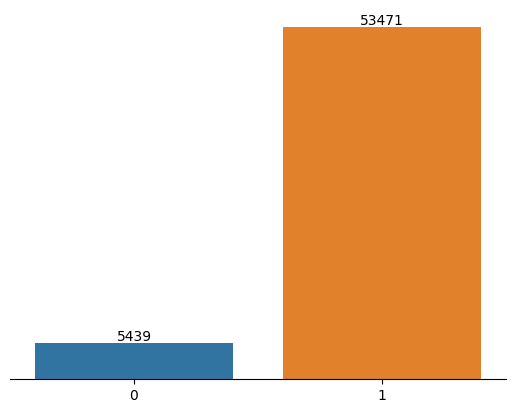

In [17]:
# plotar a distribuição de polaridade no conjunto de treino
# após o enriquecimento.
plotar_distribuicao_polaridade(train_enrequecido)